<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/OSA_Using_Neural_Additive_Model_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
df = pd.read_csv('OSA_Data_April_2023_1.csv').dropna()

# Check class distribution
class_counts = df['OSA'].value_counts()

In [64]:
df.head()

,Age,Sex,Height,Weight,BMI,Neck,MF,OSA
0,49,0,66.0,127,0,0,0,0
1,42,0,66.0,165,0,0,0,0
2,58,1,68.0,138,0,0,0,0
3,44,0,60.0,118,0,0,0,0
4,55,0,64.0,136,0,0,0,0


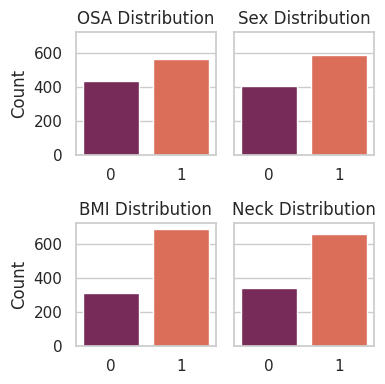

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['text.usetex'] = False

features = ['OSA', 'Sex', 'BMI', 'Neck']

fig, axes = plt.subplots(2, 2, figsize=(4, 4), sharey=True)

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.countplot(ax=axes[row, col], data=df, x=feature, hue=feature, palette='rocket', legend=False)
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('Count' if col == 0 else '')

plt.tight_layout()
plt.savefig('osa_feature_distributions.png', dpi=100)
plt.show()


In [66]:
# Feature ranking using correlation
corr = df.corr()
abs_corr = corr.abs().sort_values(by='OSA', ascending=False)
rank = abs_corr['OSA'].rank(ascending=False).astype(int)

# Balance the dataset using oversampling
from imblearn.over_sampling import RandomOverSampler
X = df.drop('OSA', axis=1)
y = df['OSA']
X_resampled, y_resampled = RandomOverSampler().fit_resample(X, y)
df_balanced = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['OSA'])], axis=1)

In [67]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop('OSA', axis=1), df_balanced['OSA'], test_size=0.2, random_state=42)

In [68]:
# Feature selection
selector = SelectKBest(f_classif, k=7)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [69]:
# Standardization
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_selected)
X_test_scaled = sc.transform(X_test_selected)

In [70]:
# Build a Keras NAM-like model with one hidden layer per feature
input_dim = X_train_scaled.shape[1]
inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [71]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

# Predictions
y_train_pred_proba = model.predict(X_train_scaled).ravel()
y_test_pred_proba = model.predict(X_test_scaled).ravel()
y_train_pred = (y_train_pred_proba > 0.5).astype(int)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


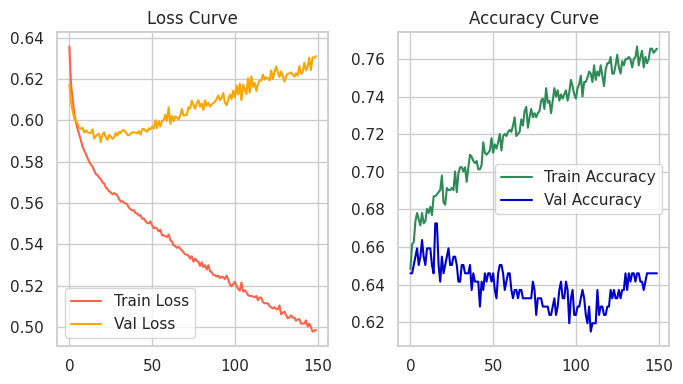

In [72]:
# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].plot(history.history['loss'], label='Train Loss', color='tomato')
axs[0].plot(history.history['val_loss'], label='Val Loss', color='orange')
axs[0].set_title('Loss Curve')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Train Accuracy', color='seagreen')
axs[1].plot(history.history['val_accuracy'], label='Val Accuracy', color='mediumblue')
axs[1].set_title('Accuracy Curve')
axs[1].legend()
plt.tight_layout()
plt.show()

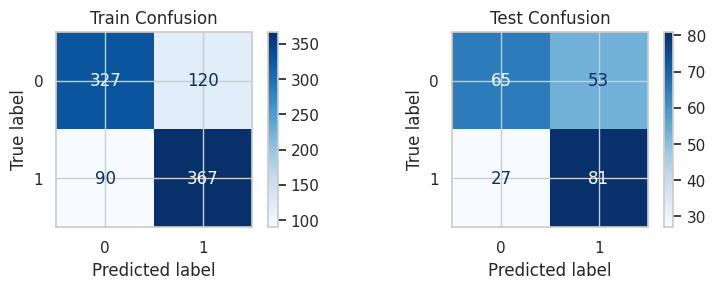

In [73]:
# Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax[0], cmap='Blues')
ax[0].set_title('Train Confusion')
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax[1], cmap='Blues')
ax[1].set_title('Test Confusion')
plt.tight_layout()
plt.show()

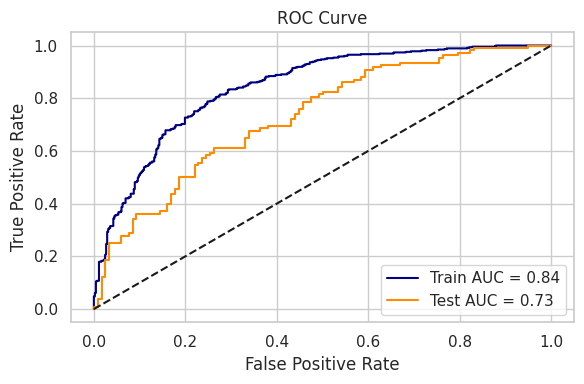

In [74]:
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc(fpr_train, tpr_train):.2f}", color="navy")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc(fpr_test, tpr_test):.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics for training data
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# # Print results
# print("Training Metrics:")
# print(f"Accuracy:  {train_acc:.4f}")
# print(f"Precision: {train_prec:.4f}")
# print(f"Recall:    {train_rec:.4f}")
# print(f"F1 Score:  {train_f1:.4f}\n")

# print("Testing Metrics:")
# print(f"Accuracy:  {test_acc:.4f}")
# print(f"Precision: {test_prec:.4f}")
# print(f"Recall:    {test_rec:.4f}")
# print(f"F1 Score:  {test_f1:.4f}")


In [76]:
import pandas as pd

# Prepare the data as a dictionary
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Train": [train_acc, train_prec, train_rec, train_f1],
    "Test": [test_acc, test_prec, test_rec, test_f1]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
metrics_df.T


,0,1,2,3
Metric,Accuracy,Precision,Recall,F1 Score
Train,0.767699,0.753593,0.803063,0.777542
Test,0.646018,0.604478,0.75,0.669421
